In [1]:
import datasets
import tqdm

## Load dataset

These are [Huggingface dataset](https://huggingface.co/docs/datasets/en/index) formats.

In [2]:
opt_dataset = datasets.Dataset.load_from_disk("../data/additional-optimizations/")
td_dataset = datasets.Dataset.load_from_disk("../data/additional-torsiondrives/")

Datasets are represented with the features in each entry.

In [3]:
opt_dataset

Dataset({
    features: ['smiles', 'coords', 'energy', 'forces'],
    num_rows: 70
})

Datasets can be indexed to get a single entry. "coords", "forces", etc. are stored as flat lists of floats.

In [4]:
opt_dataset[0]

{'smiles': '[H:14][C:3]1=[C:2]([N:11]([N:10]=[C:4]1[C:5]23[C:6]([C:7]([C:8]2([H:18])[H:19])([C:9]3([H:20])[H:21])[H:17])([H:15])[H:16])[H:22])[N:1]([H:12])[H:13]',
 'coords': tensor([-1.7365,  1.3097,  5.1288, -1.5198,  1.1527,  3.7460, -0.6614,  0.3525,
          3.0057, -0.8821,  0.7326,  1.6502, -0.2310,  0.1866,  0.4400, -0.4846,
          0.6215, -1.0329,  0.5960, -0.5005, -1.1146,  1.2970,  0.1879,  0.0944,
         -0.2535, -1.2926, -0.0766, -1.8106,  1.6883,  1.5537, -2.1830,  1.9305,
          2.8444, -1.0775,  0.7501,  5.6606, -2.6807,  1.0490,  5.4048,  0.0104,
         -0.4076,  3.3820, -1.4734,  0.3898, -1.4397, -0.1691,  1.6355, -1.2960,
          1.0740, -0.8972, -2.0142,  1.7470,  1.1697, -0.0845,  1.9392, -0.4433,
          0.7182,  0.2762, -2.0313,  0.5348, -1.2254, -1.6684, -0.4125, -2.8092,
          2.6975,  3.0476]),
 'energy': tensor([-298509.5312]),
 'forces': tensor([ 8.6516e-03,  9.9962e-03, -2.1068e-02, -6.0739e-02, -7.5098e-02,
          1.4797e-02,  6.7018e

We'll need to re-convert to PyTorch.

In [5]:
# reformat dataset lists to torch tensors
opt_dataset.set_format(
    "torch", columns=["energy", "coords", "forces"], output_all_columns=True
)
td_dataset.set_format(
    "torch", columns=["energy", "coords", "forces"], output_all_columns=True
)

In [6]:
opt_dataset[0]

{'coords': tensor([-1.7365,  1.3097,  5.1288, -1.5198,  1.1527,  3.7460, -0.6614,  0.3525,
          3.0057, -0.8821,  0.7326,  1.6502, -0.2310,  0.1866,  0.4400, -0.4846,
          0.6215, -1.0329,  0.5960, -0.5005, -1.1146,  1.2970,  0.1879,  0.0944,
         -0.2535, -1.2926, -0.0766, -1.8106,  1.6883,  1.5537, -2.1830,  1.9305,
          2.8444, -1.0775,  0.7501,  5.6606, -2.6807,  1.0490,  5.4048,  0.0104,
         -0.4076,  3.3820, -1.4734,  0.3898, -1.4397, -0.1691,  1.6355, -1.2960,
          1.0740, -0.8972, -2.0142,  1.7470,  1.1697, -0.0845,  1.9392, -0.4433,
          0.7182,  0.2762, -2.0313,  0.5348, -1.2254, -1.6684, -0.4125, -2.8092,
          2.6975,  3.0476]),
 'energy': tensor([-298509.5312]),
 'forces': tensor([ 8.6516e-03,  9.9962e-03, -2.1068e-02, -6.0739e-02, -7.5098e-02,
          1.4797e-02,  6.7018e-02,  6.8418e-02,  1.4632e-02, -1.8251e-02,
         -5.5096e-02,  2.0181e-02, -4.5286e-02,  5.9464e-02, -4.5025e-02,
         -3.8120e-03, -6.7527e-03,  5.1948e-03

In [7]:
len(opt_dataset)

70

In [8]:
len(td_dataset[0]["coords"])

1584

## Fitting

For how to fit a force field to optimization data from a SMIRNOFF force field, here's an [example I put together for the IRL Irvine meeting](https://openforcefield.atlassian.net/wiki/spaces/MEET/pages/3440508935/Hackathon+How+to+train+your+force+field+with+smee) (`run-smee-fit-from-qca-data-commented.ipynb` where you can largely follow on from the "Assign parameters to molecules in the dataset" heading.

The only note is that the `descent.targets.energy.predict` function would have to be re-written to not include forces in the objective and prediction if they're not in the data.

In [9]:
from utils import ff_to_csys

chemical_system = ff_to_csys("openff-2.2.1.offxml")

In [10]:
from besmarts.core.assignments import graph_db as GraphDb
from besmarts.core.assignments import graph_db_add_single_molecule_state
from besmarts.core.assignments import graph_db_address as GraphDbAddress
from besmarts.mechanics.fits import (
    objective_config_energy_total as ObjectiveConfigEnergyTotal,
)
from besmarts.mechanics.fits import objective_config_gradient as ObjectiveConfigGradient
from besmarts.mechanics.fits import objective_config_position as ObjectiveConfigPosition
from besmarts.mechanics.fits import objective_tier as ObjectiveTier
from utils import data_to_graph_assignment

graph_db = GraphDb()
eid = 0
objectives = []
n_entries = 1 # number of entries from each dataset to include, 0 for all

# First, the optimizations
for entry in list(opt_dataset)[:n_entries or len(opt_dataset)]:
    smiles = entry["smiles"]

    # Create mappings between the data and the graph implied by the SMILES
    positions = data_to_graph_assignment(
        smiles=smiles,
        data=entry["coords"].reshape(-1, 3),
    )
    gradients=data_to_graph_assignment(
        smiles=smiles,
        data=entry["forces"].reshape(-1, 3),
    )
    energy=entry["energy"][0]

    # Add the data to the graph
    graph_db_add_single_molecule_state(
        graph_db,
        positions=positions,
        gradients=gradients,
        energy=energy,
    )

    # Create objectives using the data
    objectives.extend([
        ObjectiveConfigPosition(
            GraphDbAddress(
                eid=[eid],
            ),
            scale=100
        ),
        ObjectiveConfigGradient(
            GraphDbAddress(
                eid=[eid],
            ),
            scale=1e-5,
        ),
        ObjectiveConfigEnergyTotal(
            GraphDbAddress(
                eid=[eid],
            ),
            scale=1
        ),
    ])

    # Increment the entry index into the graph
    eid += 1

# Next, the torsion drives
for entry in list(td_dataset)[:n_entries or len(opt_dataset)]:
    smiles = entry["smiles"]

    n_frames = len(entry["energy"])

    for coords, energy in zip(entry["coords"].reshape(n_frames, -1, 3), entry["energy"]):
        positions = data_to_graph_assignment(
            smiles=smiles,
            data=coords,
        )
    
    
        graph_db_add_single_molecule_state(
            graph_db,
            positions=positions,
            energy=energy,
        )

        objectives.append(
            ObjectiveConfigEnergyTotal(
                GraphDbAddress(
                    eid=[eid],
                ),
                scale=1
            )
        )
        
        eid += 1

objective_tier = ObjectiveTier()
objective_tier.objectives = dict(enumerate(objectives))

Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies
Appending energies


In [11]:
from besmarts.mechanics.fits import gdb_to_physical_systems
physical_systems = gdb_to_physical_systems(graph_db, chemical_system)

Warning, aromaticity set to OEAroModel_MDL with RDKit. Model set to RDKit MDL. Expect differences.
[H:14][C:3]1=[C:2]([N:11]([N:10]=[C:4]1[C:5]23[C:6]([C:7]([C:8]2([H:18])[H:19])([C:9]3([H:20])[H:21])[H:17])([H:15])[H:16])[H:22])[N:1]([H:12])[H:13]
Charges: [H:14][C:3]1=[C:2]([N:11]([N:10]=[C:4]1[C:5]23[C:6]([C:7]([C:8]2([H:18])[H:19])([C:9]3([H:20])[H:21])[H:17])([H:15])[H:16])[H:22])[N:1]([H:12])[H:13] [0.162, -0.3453, 0.0913, -0.0396, -0.5068, 0.3836, -0.1413, -0.0754, -0.1137, -0.0754, 0.0572, 0.0572, -0.0754, 0.0572, 0.0572, 0.0947, 0.0572, 0.0572, 0.3227, -0.7812, 0.3798, 0.3798]
[H:6][C@:5]1([C:7]([C:8]([C:9]([N+:10]1([H:21])[H:22])([H:19])[H:20])([H:17])[H:18])([H:15])[H:16])[C:2](=[O:1])[N:3]([H:11])[C:4]([H:12])([H:13])[H:14]
Charges: [H:6][C@:5]1([C:7]([C:8]([C:9]([N+:10]1([H:21])[H:22])([H:19])[H:20])([H:17])[H:18])([H:15])[H:16])[C:2](=[O:1])[N:3]([H:11])[C:4]([H:12])([H:13])[H:14] [0.1287, 0.0565, -0.0924, -0.0994, 0.1448, -0.803, 0.4568, 0.4568, 0.1062, 0.1062, 0.1007, 0

In [12]:
model = {model.name: i for i, model in enumerate(chemical_system.models)}
model

{'Bonds': 0,
 'Angles': 1,
 'Torsions': 2,
 'OutOfPlanes': 3,
 'Electrostatics': 4,
 'vdW': 5}

In [13]:
split_on_models = {
    model['Torsions']: ["t17"]
}

In [14]:
from besmarts.mechanics.fits import forcefield_optimization_strategy_default

fitting_strategy = forcefield_optimization_strategy_default(chemical_system, models=split_on_models)

In [15]:
from besmarts.mechanics.fits import chemical_objective
force_field_objective = chemical_objective

In [16]:
# Fit only the parameters we split on
objective_tier.fit_models = list(split_on_models)
# Only do 1 round of fitting at each tier (required to have 3 tiers)
objective_tier.step_limit = 1

objective_tiers = [objective_tier, objective_tier, objective_tier]

In [17]:
from besmarts.mechanics.fits import ff_optimize
from besmarts.core import configs
configs.processors = 1
configs.remote_compute_enable = False
configs.workqueue_port = 57575
newcsys, (P0, P), (C0, C) = ff_optimize(
    csys0=chemical_system,
    gdb=graph_db,
    psystems=physical_systems,
    strategy=fitting_strategy,
    chemical_objective=force_field_objective,
    initial_objective=objective_tiers[0],
    tiers=objective_tiers[1:-1],
    final_objective=objective_tiers[-1]
)

# This seems to break because besmarts is internally mixing up parameters and passing
# floats to openmm

Optimization strategy is building steps...
2025-03-14 17:21:52.334021 The optimization strategy has the following iterations:
->   1:00. op= 1 m=[2] a=[0] b=1->1 d=0->0 n=0->0
->   1:01. op=-1 m=[2] a=[0] b=0->0 d=0->0 n=0->0
     2:00. op= 1 m=[2] a=[0] b=2->2 d=0->0 n=0->0
     2:01. op=-1 m=[2] a=[0] b=0->0 d=0->0 n=0->0
workspace listening on local host. Remote connections prohibited.

Initial parameter assignments of dataset:
Model:
Tree:
 0   0 Bonds  
 1   0  b1   [#6X4:1]-[#6X4:2] k: [430.4753865522] l: [1.533682189836]
 1   0  b2   [#6X4:1]-[#6X3:2] k: [478.5938624291] l: [1.509906088505]
 1   0  b3   [#6X4:1]-[#6X3:2]=[#8X1+0] k: [404.5865966221] l: [1.529107327625]
 1   0  b4   [#6X3:1]-[#6X3:2] k: [534.9004011769] l: [1.467813669186]
 1   0  b6   [#6X3:1]=[#6X3:2] k: [904.1364741993] l: [1.373322617043]
 1   0  b7   [#6:1]-[#7:2] k: [451.7828325538] l: [1.477165026987]
 1   0  b8   [#6X3:1]-[#7X3:2] k: [658.1801467822] l: [1.389594660959]
 1   0  b9   [#6X4:1]-[#7X3:2]-[#6X

/home/joshmitchell/Documents/openff/besmarts/besmarts-scipy/python/besmarts/mechanics/optimizers_scipy.py:1419: RuntimeWarning: Method trust-ncg cannot handle bounds.
  scipy.optimize.minimize(


[H:14][C:3]1=[C:2]([N:11]([N:10]=[C:4]1[C:5]23[C:6]([C:7]([C:8]2([H:18])[H:19])([C:9]3([H:20])[H:21])[H:17])([H:15])[H:16])[H:22])[N:1]([H:12])[H:13]
Charges: [H:14][C:3]1=[C:2]([N:11]([N:10]=[C:4]1[C:5]23[C:6]([C:7]([C:8]2([H:18])[H:19])([C:9]3([H:20])[H:21])[H:17])([H:15])[H:16])[H:22])[N:1]([H:12])[H:13] [0.162, -0.3453, 0.0913, -0.0396, -0.5068, 0.3836, -0.1413, -0.0754, -0.1137, -0.0754, 0.0572, 0.0572, -0.0754, 0.0572, 0.0572, 0.0947, 0.0572, 0.0572, 0.3227, -0.7812, 0.3798, 0.3798]


TypeError: in method 'PeriodicTorsionForce_addTorsion', argument 6 of type 'int'

In [ ]:
chemical_system.models[model['Torsions']]

In [ ]:
chemical_system.models[model["Torsions"]].topology_terms['n'].values

In [ ]:
chemical_system.models[model["Torsions"]].procedures[0].smarts_hierarchies[0].smarts

In [ ]:
{i: model for i, model in enumerate(physical_systems[0].models)}

In [ ]:
psys=physical_systems[0]
pmodel = psys.models[model["Torsions"]]

In [ ]:
pmodel.values

In [ ]:
for psys in physical_systems.values():
    pmodel = psys.models[model["Torsions"]]
    for d in pmodel.values:
        for v in d.values():
            for n in v['n']:
                assert isinstance(n, int), n
                assert n > 0, n

In [ ]:
from besmarts.mechanics.fits import generate_candidates


In [ ]:
physical_systems

/tmp/ipykernel_1909794/3315764551.py:3: AtomMappingWarning: Warning! Fully mapped SMILES pattern passed to `from_smiles`. The atom map is stored as a property in `Molecule._properties`, but these indices are NOT used to determine atom ordering. To use these indices for atom ordering, use `Molecule.from_mapped_smiles`.
  Molecule.from_smiles(opt_dataset[0]['smiles']).visualize('rdkit')


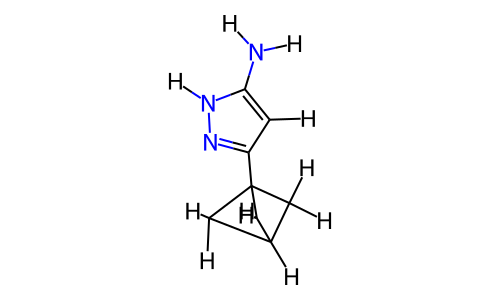

In [20]:
from openff.toolkit import Molecule

Molecule.from_smiles(opt_dataset[0]['smiles']).visualize('rdkit')